图片数据一般有两种情况：

1、所有图片放在一个文件夹内，另外有一个txt文件显示标签。


2、不同类别的图片放在不同的文件夹内，文件夹就是图片的类别。

针对这两种不同的情况，数据集的准备也不相同，第一种情况可以自定义一个Dataset，第二种情况直接调用torchvision.datasets.ImageFolder来处理。下面分别进行说明：


In [1]:
import torch
import torchvision
from torchvision import transforms, utils
from PIL import Image
import numpy as np
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

In [3]:
trainset = torchvision.datasets.ImageFolder('D:/CIFAR-10/images/train',transform=transform)
valset = torchvision.datasets.ImageFolder('D:/CIFAR-10/images/val',transform=transform)

In [4]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=24,shuffle=True,num_workers=0)
valloader = torch.utils.data.DataLoader(valset, batch_size=12,shuffle=False,num_workers=0)

In [5]:
trainloader.dataset.class_to_idx

{'cat': 0, 'dog': 1}

In [6]:
valloader.dataset.class_to_idx

{'cat': 0, 'dog': 1}

## 迁移学习网络



In [7]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# resnet18 = models.resnet18(pretrained=True)
# alexnet = models.alexnet(pretrained=True)
# squeezenet = models.squeezenet1_0(pretrained=True)
# vgg16 = models.vgg16(pretrained=True)
# densenet = models.densenet161(pretrained=True)
# inception = models.inception_v3(pretrained=True)
# shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
# mobilenet = models.mobilenet_v2(pretrained=True)
# mnasnet = models.mnasnet1_0(pretrained=True)


#### 定义训练模型的函数

In [8]:
def train(net, save_path):
    loss_function = nn.CrossEntropyLoss() 
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
    
    best_acc = 0.0
    for epoch in range(30):
        # train
        net.train()
        running_loss = 0.0
        for step, data in enumerate(trainloader, start=0):
            images, labels = data
            optimizer.zero_grad()
            outputs = net(images.to(device))
            loss = loss_function(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            # print train process
            rate = (step + 1) / len(trainloader)
            a = "*" * int(rate * 50)
            b = "." * int((1 - rate) * 50)
            print("\rtrain loss: {:^3.0f}%[{}->{}]{:.3f}".format(int(rate * 100), a, b, loss), end="")
        print()

        # validate
        net.eval()
        acc = 0.0  # accumulate accurate number / epoch
        with torch.no_grad():
            for val_data in valloader:
                val_images, val_labels = val_data
                outputs = net(val_images.to(device))
                predict_y = torch.max(outputs, dim=1)[1]
                acc += (predict_y == val_labels.to(device)).sum().item()
            val_accurate = acc / len(valset)
            if val_accurate > best_acc:
                best_acc = val_accurate
                torch.save(net.state_dict(), save_path)
            print('[epoch %d] test_loss: %.3f  test_accuracy: %.3f' %
                  (epoch + 1, running_loss / step, val_accurate))

    print('Finished Training')

#### 定义一个测试的函数

In [9]:
import matplotlib.pyplot as plt
def test(path, model):
    # 读取要预测的图片
    img = Image.open(path).convert('RGB') # 读取图像

    data_transform = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    class_indict = ["cat", "dog"]
    plt.imshow(img)
    img = data_transform(img)
    img = img.to(device)
    img = torch.unsqueeze(img, dim=0)
    model.eval()
    with torch.no_grad():
        # predict class
        output = torch.squeeze(model(img))
        predict = torch.softmax(output, dim=0)
        predict_cla = torch.argmax(predict).data.cpu().numpy()
    print(class_indict[predict_cla], predict[predict_cla].data.cpu().numpy())
    plt.show()

### 1.AlexNet

In [10]:
# 导入Pytorch封装的AlexNet网络模型
alexnet = models.alexnet(pretrained=True)
# 固定卷积层参数
for param in alexnet.parameters():
    param.requires_grad = False
    
# 获取最后一个全连接层的输入通道数
num_input = alexnet.classifier[6].in_features
# 获取全连接层的网络结构
feature_model = list(alexnet.classifier.children())
# 去掉原来的最后一层
feature_model.pop()
# 添加上适用于自己数据集的全连接层
feature_model.append(nn.Linear(num_input, 2))
# 仿照这里的方法，可以修改网络的结构，不仅可以修改最后一个全连接层
# 还可以为网络添加新的层
# 重新生成网络的后半部分
alexnet.classifier = nn.Sequential(*feature_model)
for param in alexnet.classifier.parameters():
    param.requires_grad = True
alexnet = alexnet.to(device)
#打印一下
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [11]:
train(alexnet, "D:/CIFAR-10/images/model/alexnet")

train loss: 100%[**************************************************->]2.399
[epoch 1] test_loss: 0.832  test_accuracy: 0.731
train loss: 100%[**************************************************->]3.602
[epoch 2] test_loss: 1.251  test_accuracy: 0.687
train loss: 100%[**************************************************->]0.000
[epoch 3] test_loss: 1.820  test_accuracy: 0.847
train loss: 100%[**************************************************->]0.197
[epoch 4] test_loss: 0.587  test_accuracy: 0.876
train loss: 100%[**************************************************->]0.000
[epoch 5] test_loss: 2.589  test_accuracy: 0.825
train loss: 100%[**************************************************->]67.892
[epoch 6] test_loss: 15.244  test_accuracy: 0.622
train loss: 100%[**************************************************->]nan6056243793278265196544.000
[epoch 7] test_loss: nan  test_accuracy: 0.428
train loss: 100%[**************************************************->]nan
[epoch 8] test_loss: nan  t

cat nan


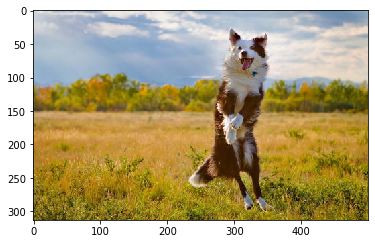

In [12]:
test("D:/CIFAR-10/images/test/6.jpg",alexnet)

### 2.VGGNet16

In [13]:
vgg16 = models.vgg16_bn(pretrained=True)
# 固定模型权重
for param in vgg16.parameters():
    param.requires_grad = False
    
# 最后加一个分类器
vgg16.classifier[6] = nn.Sequential(nn.Linear(4096, 2))
for param in vgg16.classifier[6].parameters():
    param.requires_grad = True
    
vgg16 = vgg16.to(device)

In [14]:
train(vgg16, "D:/CIFAR-10/images/model/vgg16")

train loss: 100%[**************************************************->]0.001
[epoch 1] test_loss: 0.167  test_accuracy: 0.938
train loss: 100%[**************************************************->]0.067
[epoch 2] test_loss: 0.054  test_accuracy: 0.952
train loss: 100%[**************************************************->]0.062
[epoch 3] test_loss: 0.059  test_accuracy: 0.956
train loss: 100%[**************************************************->]0.001
[epoch 4] test_loss: 0.055  test_accuracy: 0.952
train loss: 100%[**************************************************->]0.744
[epoch 5] test_loss: 0.059  test_accuracy: 0.964
train loss: 100%[**************************************************->]0.336
[epoch 6] test_loss: 0.042  test_accuracy: 0.948
train loss: 100%[**************************************************->]0.002
[epoch 7] test_loss: 0.024  test_accuracy: 0.952
train loss: 100%[**************************************************->]0.095
[epoch 8] test_loss: 0.024  test_accuracy: 0.952


dog 0.99725807


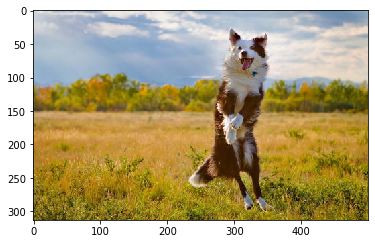

In [15]:
test("D:/CIFAR-10/images/test/6.jpg",vgg16)

### 3.ResNet18

In [16]:
resnet18 = models.resnet18(pretrained=True)

for param in resnet18.parameters():
    param.requires_grad = False
    
inchannel = resnet18.fc.in_features
resnet18.fc = nn.Linear(inchannel, 2)
for param in resnet18.fc.parameters():
    param.requires_grad = True
    
resnet18 = resnet18.to(device)

In [17]:
train(resnet18,"D:/CIFAR-10/images/model/resnet18")

train loss: 100%[**************************************************->]0.010
[epoch 1] test_loss: 0.262  test_accuracy: 0.882
train loss: 100%[**************************************************->]0.004
[epoch 2] test_loss: 0.186  test_accuracy: 0.944
train loss: 100%[**************************************************->]0.001
[epoch 3] test_loss: 0.108  test_accuracy: 0.948
train loss: 100%[**************************************************->]0.227
[epoch 4] test_loss: 0.055  test_accuracy: 0.934
train loss: 100%[**************************************************->]0.018
[epoch 5] test_loss: 0.044  test_accuracy: 0.894
train loss: 100%[**************************************************->]0.004
[epoch 6] test_loss: 0.099  test_accuracy: 0.940
train loss: 100%[**************************************************->]0.009
[epoch 7] test_loss: 0.063  test_accuracy: 0.940
train loss: 100%[**************************************************->]0.000
[epoch 8] test_loss: 0.047  test_accuracy: 0.924


dog 0.99990165


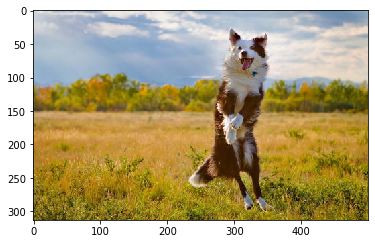

In [18]:
test("D:/CIFAR-10/images/test/6.jpg",resnet18)

### 4.DenseNet

In [19]:
densenet121 = models.densenet121(pretrained=True)

for param in densenet121.parameters():
    param.requires_grad = False
    
inchannel = densenet121.classifier.in_features
densenet121.classifier = nn.Linear(inchannel, 2)
for param in densenet121.classifier.parameters():
    param.requires_grad = True
    
densenet121 = densenet121.to(device)

In [20]:
train(densenet121,"D:/CIFAR-10/images/model/densenet121")

train loss: 100%[**************************************************->]0.257
[epoch 1] test_loss: 0.158  test_accuracy: 0.950
train loss: 100%[**************************************************->]0.264
[epoch 2] test_loss: 0.130  test_accuracy: 0.896
train loss: 100%[**************************************************->]0.063
[epoch 3] test_loss: 0.097  test_accuracy: 0.948
train loss: 100%[**************************************************->]0.080
[epoch 4] test_loss: 0.058  test_accuracy: 0.934
train loss: 100%[**************************************************->]0.561
[epoch 5] test_loss: 0.090  test_accuracy: 0.948
train loss: 100%[**************************************************->]0.001
[epoch 6] test_loss: 0.058  test_accuracy: 0.942
train loss: 100%[**************************************************->]0.006
[epoch 7] test_loss: 0.049  test_accuracy: 0.948
train loss: 100%[**************************************************->]0.000
[epoch 8] test_loss: 0.033  test_accuracy: 0.932


cat 0.99999917


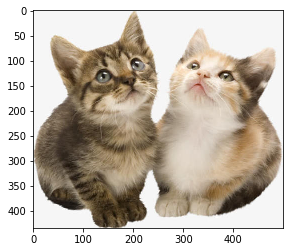

In [29]:
test("D:/CIFAR-10/images/test/9.jpg",densenet121)

### 5.MobileNet V2

In [31]:
mobilenet = models.mobilenet_v2(pretrained=True)

for param in mobilenet.parameters():
    param.requires_grad = False
    
# 最后加一个分类器
mobilenet.classifier[1] = nn.Sequential(nn.Linear(1280, 2))
for param in mobilenet.classifier[1].parameters():
    param.requires_grad = True
    
mobilenet = mobilenet.to(device)

In [32]:
train(mobilenet,"D:/CIFAR-10/images/model/mobilenet")

train loss: 100%[**************************************************->]0.161
[epoch 1] test_loss: 0.282  test_accuracy: 0.944
train loss: 100%[**************************************************->]0.317
[epoch 2] test_loss: 0.094  test_accuracy: 0.920
train loss: 100%[**************************************************->]0.008
[epoch 3] test_loss: 0.239  test_accuracy: 0.922
train loss: 100%[**************************************************->]0.098
[epoch 4] test_loss: 0.147  test_accuracy: 0.938
train loss: 100%[**************************************************->]0.001
[epoch 5] test_loss: 0.102  test_accuracy: 0.886
train loss: 100%[**************************************************->]0.036
[epoch 6] test_loss: 0.215  test_accuracy: 0.938
train loss: 100%[**************************************************->]0.005
[epoch 7] test_loss: 0.090  test_accuracy: 0.934
train loss: 100%[**************************************************->]0.001
[epoch 8] test_loss: 0.121  test_accuracy: 0.882


dog 0.9954176


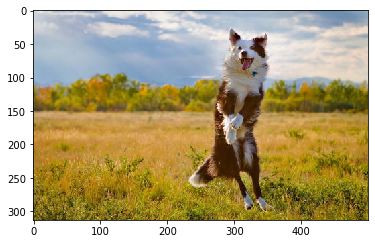

In [36]:
test("D:/CIFAR-10/images/test/6.jpg",mobilenet)

### 6.ShuffleNetV2

In [38]:
shufflenet = models.shufflenet_v2_x1_0(pretrained=True)

for param in mobilenet.parameters():
    param.requires_grad = False
    
# 最后加一个分类器
inchannel = shufflenet.fc.in_features
shufflenet.fc = nn.Linear(inchannel, 2)
for param in shufflenet.fc.parameters():
    param.requires_grad = True
    
shufflenet = shufflenet.to(device)

In [40]:
train(shufflenet,"D:/CIFAR-10/images/model/shufflenet")

train loss: 100%[**************************************************->]0.667
[epoch 1] test_loss: 0.703  test_accuracy: 0.436
train loss: 100%[**************************************************->]0.617
[epoch 2] test_loss: 0.673  test_accuracy: 0.625
train loss: 100%[**************************************************->]0.604
[epoch 3] test_loss: 0.623  test_accuracy: 0.855
train loss: 100%[**************************************************->]0.495
[epoch 4] test_loss: 0.515  test_accuracy: 0.861
train loss: 100%[**************************************************->]0.322
[epoch 5] test_loss: 0.355  test_accuracy: 0.910
train loss: 100%[**************************************************->]0.193
[epoch 6] test_loss: 0.208  test_accuracy: 0.908
train loss: 100%[**************************************************->]0.164
[epoch 7] test_loss: 0.132  test_accuracy: 0.906
train loss: 100%[**************************************************->]0.161
[epoch 8] test_loss: 0.087  test_accuracy: 0.934


cat 0.666592


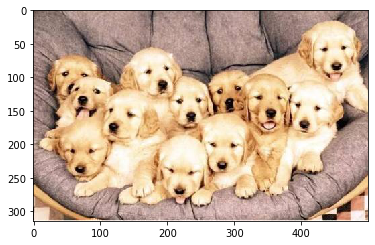

In [48]:
test("D:/CIFAR-10/images/test/7.jpg",shufflenet)

## 总结

前面分别使用了Alexnet、VGGNet、ResNet、DenseNet、MobileNet、ShuffleNet 六种网络结构来试验迁移学习，发现效果其实是都差不多都在94%左右。

**注**：这里并没有使用Inception网络结构，因为他的图片输入大小为（299,299），且他的网络输出结果有三个值，所以对应训练过程的损失也有三部分：
```
images, labels = data
optimizer.zero_grad()
logits, aux_logits2, aux_logits1 = net(images.to(device))
loss0 = loss_function(logits, labels.to(device))
loss1 = loss_function(aux_logits1, labels.to(device))
loss2 = loss_function(aux_logits2, labels.to(device))
loss = loss0 + loss1 * 0.3 + loss2 * 0.3
loss.backward()
optimizer.step()
```


总的来说迁移学习优点真的是太好了，速度快，准确率高，而且还不用担心GPU内存不够，CPU都能给你跑。


#### 最后再附上一段代码，就当做前面所有的整合吧

In [ ]:
import torch.nn as nn
from torchvision import datasets, models

# 你要分类的种类数
num_classes = 2

# 训练的批量大小（根据您拥有的内存量而变化）
BATCH_SIZE = 128

# 用于特征提取的标志。当为False时，我们会微调整个模型；当为True时，我们只会更新重塑的图层参数
feature_extract = True

#是否改变卷及层的参数
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
        # 初始化这些变量，这些变量将在此if语句中设置。这些变量中的每一个都是特定于模型的。
        model_ft = None
        input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG16_bn
        """
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224
                
    elif model_name == "shufflenet":
        """ShuffleNetV2
        """
        model_ft = models.shufflenet_v2_x1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "mobilenet":
        """ MobileNet V2 
        """
        model_ft = models.mobilenet_v2(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
        
    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "vgg"#调用模型的名字
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
#print(model_ft, input_size)

